In [8]:

%pip install pandas numpy scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay, classification_report, confusion_matrix
)

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42
DATA_DIR = ""  # set path if your CSVs are in another folder
TRAIN_PATH = os.path.join(DATA_DIR, "application_train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "application_test.csv")

# Handy helpers
def build_ohe():
    """Create an OneHotEncoder that works across sklearn versions."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

Note: you may need to restart the kernel to use updated packages.


In [9]:
# =========================================================
# 1) LOAD DATA
# =========================================================
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train shape:", train.shape, " | test shape:", test.shape)
print("columns in train:", len(train.columns), " | columns in test:", len(test.columns))

TARGET = "TARGET"
ID_COL = "SK_ID_CURR"
assert TARGET in train.columns, "TARGET not found in application_train.csv"
assert ID_COL in train.columns and ID_COL in test.columns, f"{ID_COL} must exist in both files"

train shape: (307511, 122)  | test shape: (48744, 121)
columns in train: 122  | columns in test: 121


In [10]:
# =========================================================
# 2) QUICK SANITY / BASIC CLEANING
# =========================================================
# Known sentinel for 'unknown' employment in this dataset
for df in (train, test):
    if "DAYS_EMPLOYED" in df.columns:
        df.loc[df["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

print("TARGET distribution (train):")
print(train[TARGET].value_counts(normalize=True).rename("proportion"))

# Optional quick peek
print("\nNumeric/Categorical counts in train:")
print(train.dtypes.value_counts())

# Make sure we don't accidentally keep TARGET with features later

TARGET distribution (train):
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Numeric/Categorical counts in train:
float64    66
int64      40
object     16
Name: count, dtype: int64


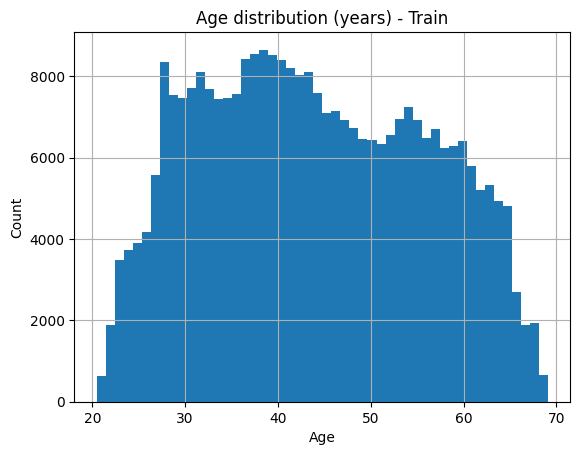

In [11]:
# =========================================================
# 3) FEATURE ENGINEERING (light, safe)
# =========================================================
def add_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Age (years) from DAYS_BIRTH (negative days)""
    if "DAYS_BIRTH" in out.columns:
        out["AGE_YEARS"] = (-out["DAYS_BIRTH"] / 365.25).astype(float)
    # Ratios
    if {"AMT_CREDIT","AMT_INCOME_TOTAL"}.issubset(out.columns):
        out["CREDIT_INCOME_RATIO"] = out["AMT_CREDIT"] / (out["AMT_INCOME_TOTAL"] + 1e-6)
    if {"AMT_ANNUITY","AMT_CREDIT"}.issubset(out.columns):
        out["ANNUITY_CREDIT_RATIO"] = out["AMT_ANNUITY"] / (out["AMT_CREDIT"] + 1e-6)
    if {"AMT_INCOME_TOTAL","CNT_FAM_MEMBERS"}.issubset(out.columns):
        # avoid divide-by-zero
        denom = out["CNT_FAM_MEMBERS"].replace(0, np.nan)
        out["INCOME_PER_PERSON"] = out["AMT_INCOME_TOTAL"] / denom
    return out

train = add_basic_features(train)
test  = add_basic_features(test)

# Optional: quick plot
if "AGE_YEARS" in train.columns:
    train["AGE_YEARS"].hist(bins=50)
    plt.title("Age distribution (years) - Train")
    plt.xlabel("Age"); plt.ylabel("Count")
    plt.show()

In [12]:
# =========================================================
# 4) TRAIN/VALIDATION SPLIT
# =========================================================
X_full = train.drop(columns=[TARGET])       # keep ID for later, we'll drop in pipeline or explicitly
y_full = train[TARGET].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.20, random_state=RANDOM_STATE, stratify=y_full
)

print("X_train:", X_train.shape, "| X_valid:", X_valid.shape)

X_train: (246008, 125) | X_valid: (61503, 125)


In [13]:
# =========================================================
# 5) PREPROCESSING SETUP
#    We'll build two pipelines:
#    A) Logistic Regression with One-Hot (uses numeric + categorical)
#    B) HistGradientBoosting on numeric features only (fast & strong baseline)
# =========================================================

# Identify columns
all_cols = X_train.columns.tolist()
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in all_cols if c not in numeric_cols]

# Remove ID column from feature processing (keep it for submission)
for lst in (numeric_cols, categorical_cols):
    if ID_COL in lst:
        lst.remove(ID_COL)

print(f"# numeric: {len(numeric_cols)} | # categorical: {len(categorical_cols)}")

# --- Pipeline A: Logistic Regression with OHE (sparse-friendly) ---
ohe = build_ohe()

num_pipe_A = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),   # safe with sparse matrices later
])

cat_pipe_A = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

prep_A = ColumnTransformer(
    transformers=[
        ("num", num_pipe_A, numeric_cols),
        ("cat", cat_pipe_A, categorical_cols),
    ],
    remainder="drop"
)

logit = LogisticRegression(
    solver="saga",      # handles large, sparse OHE
    max_iter=1000,
    class_weight="balanced",
    C=1.0,
    n_jobs=None
)

pipe_A = Pipeline(steps=[("prep", prep_A), ("model", logit)])

# --- Pipeline B: HistGradientBoosting on NUMERIC ONLY ---
num_pipe_B = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # No scaling needed for tree-based models
])

prep_B = ColumnTransformer(
    transformers=[("num", num_pipe_B, numeric_cols)],
    remainder="drop"
)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_leaf_nodes=31,
    random_state=RANDOM_STATE
)

pipe_B = Pipeline(steps=[("prep", prep_B), ("model", hgb)])

# numeric: 108 | # categorical: 16


/Users/prasanthkumar/Desktop/PYTHON/.conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



LogisticRegression + OHE ROC-AUC: 0.7505


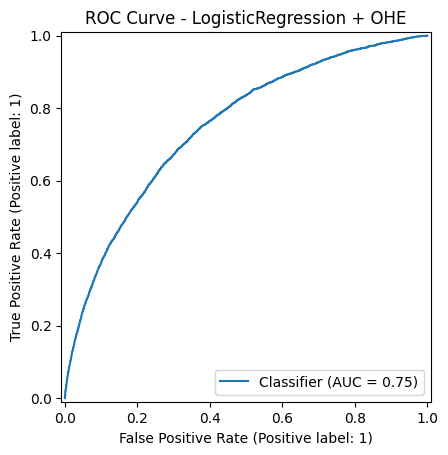

              precision    recall  f1-score   support

           0     0.9613    0.6913    0.8042     56538
           1     0.1627    0.6828    0.2627      4965

    accuracy                         0.6906     61503
   macro avg     0.5620    0.6871    0.5335     61503
weighted avg     0.8968    0.6906    0.7605     61503

Confusion matrix:
 [[39086 17452]
 [ 1575  3390]]

HistGradientBoosting (numeric only) ROC-AUC: 0.7592


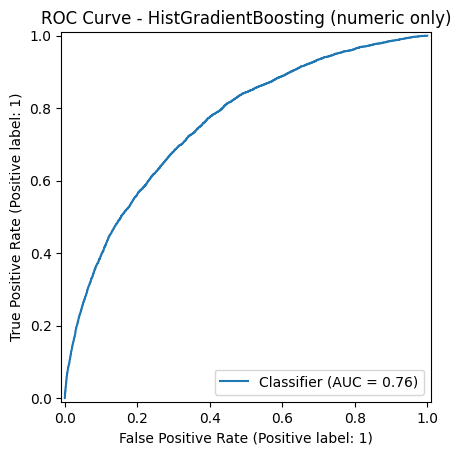

              precision    recall  f1-score   support

           0     0.9202    0.9994    0.9581     56538
           1     0.6392    0.0125    0.0245      4965

    accuracy                         0.9197     61503
   macro avg     0.7797    0.5059    0.4913     61503
weighted avg     0.8975    0.9197    0.8828     61503

Confusion matrix:
 [[56503    35]
 [ 4903    62]]


In [14]:
# =========================================================
# 6) TRAIN & EVALUATE (ROC-AUC, report, confusion matrix)
# =========================================================
def fit_eval(pipe, name):
    pipe.fit(X_train, y_train)
    # Get validation probabilities
    if hasattr(pipe[-1], "predict_proba"):
        valid_proba = pipe.predict_proba(X_valid)[:, 1]
    else:
        # Some classifiers don't implement predict_proba; use decision_function if available
        if hasattr(pipe[-1], "decision_function"):
            from sklearn.metrics import minmax_scale
            valid_proba = minmax_scale(pipe.decision_function(X_valid))
        else:
            valid_proba = pipe.predict(X_valid).astype(float)
    auc = roc_auc_score(y_valid, valid_proba)
    print(f"\n{name} ROC-AUC: {auc:.4f}")
    RocCurveDisplay.from_predictions(y_valid, valid_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()

    preds = (valid_proba >= 0.5).astype(int)
    print(classification_report(y_valid, preds, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_valid, preds))
    return auc, pipe

auc_A, pipe_A_fitted = fit_eval(pipe_A, "LogisticRegression + OHE")
auc_B, pipe_B_fitted = fit_eval(pipe_B, "HistGradientBoosting (numeric only)")

ROC-AUC: 0.7592 | PR-AUC (Average Precision): 0.2490
Best F1 threshold: 0.1439 | F1=0.3155, P=0.2448, R=0.4437
Max Recall with Precision ≥ 0.70: threshold=0.5192, P=0.7000, R=0.0113, F1=0.0222

Threshold comparison (validation):


,threshold,precision,recall,f1,specificity,TP,FP,FN,TN
0,0.5192,0.6914,0.0113,0.0222,0.9996,56,25,4909,56513
1,0.5000,0.6392,0.0125,0.0245,0.9994,62,35,4903,56503
2,0.4000,0.5143,0.0508,0.0924,0.9958,252,238,4713,56300
3,0.3500,0.4485,0.0850,0.1429,0.9908,422,519,4543,56019
4,0.3000,0.3905,0.1303,0.1954,0.9821,647,1010,4318,55528
5,0.2500,0.3499,0.1972,0.2522,0.9678,979,1819,3986,54719
6,0.2000,0.2994,0.2872,0.2932,0.9410,1426,3337,3539,53201
7,0.1439,0.2447,0.4437,0.3155,0.8797,2203,6799,2762,49739


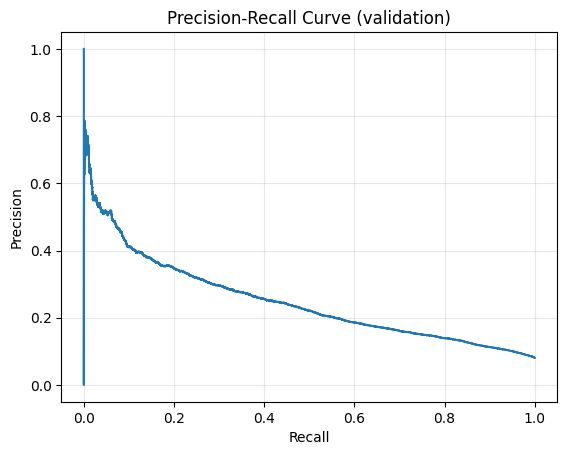


Suggested operating points:
 - Best-F1 threshold: 0.1439
 - Max-Recall @ Precision ≥ 0.70: 0.5192

Classification report @ threshold=0.5192:
              precision    recall  f1-score   support

           0     0.9201    0.9996    0.9582     56538
           1     0.6914    0.0113    0.0222      4965

    accuracy                         0.9198     61503
   macro avg     0.8057    0.5054    0.4902     61503
weighted avg     0.9016    0.9198    0.8826     61503

Confusion matrix:
[[56513    25]
 [ 4909    56]]


In [16]:
# ============================================
# Threshold sweep & report for HistGB (or best_pipe)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import minmax_scale

# ---- choose the model to analyze (prefers HistGB fitted; else best_pipe) ----
try:
    clf = pipe_B_fitted   # from your earlier cell
except NameError:
    clf = best_pipe       # fallback if you've set best_pipe earlier

# ---- get validation probabilities ----
if hasattr(clf[-1], "predict_proba"):
    y_valid_proba = clf.predict_proba(X_valid)[:, 1]
elif hasattr(clf[-1], "decision_function"):
    y_valid_proba = minmax_scale(clf.decision_function(X_valid))
else:
    # As a last resort (not ideal), use predicted labels as pseudo-probs
    y_valid_proba = clf.predict(X_valid).astype(float)

# ---- core metrics ----
roc_auc = roc_auc_score(y_valid, y_valid_proba)
ap = average_precision_score(y_valid, y_valid_proba)
print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC (Average Precision): {ap:.4f}")

prec, rec, thr = precision_recall_curve(y_valid, y_valid_proba)
# sklearn returns len(thr) = len(prec)-1; align by trimming the first prec/rec
thr = np.r_[0.0, thr]  # prepend 0 so arrays align on same length
prec = prec
rec = rec

# ---- best-F1 threshold ----
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
thr_f1 = float(thr[best_idx])
print(f"Best F1 threshold: {thr_f1:.4f} | F1={f1[best_idx]:.4f}, P={prec[best_idx]:.4f}, R={rec[best_idx]:.4f}")

# ---- highest recall at Precision >= 0.70 (tune the bar as needed) ----
PREC_BAR = 0.70
mask = prec >= PREC_BAR
if mask.any():
    idx_pr = np.argmax(rec * mask)  # max recall subject to precision bar
    thr_pr = float(thr[idx_pr])
    print(f"Max Recall with Precision ≥ {PREC_BAR:.2f}: threshold={thr_pr:.4f}, P={prec[idx_pr]:.4f}, R={rec[idx_pr]:.4f}, F1={f1[idx_pr]:.4f}")
else:
    thr_pr = None
    print(f"No threshold achieves Precision ≥ {PREC_BAR:.2f}. Try lowering PREC_BAR.")

# ---- build a candidate threshold list ----
fixed = [0.50, 0.40, 0.35, 0.30, 0.25, 0.20]
cands = list(dict.fromkeys([*fixed, thr_f1, thr_pr] if thr_pr is not None else [*fixed, thr_f1]))
cands = [t for t in cands if t is not None]
cands = sorted(cands, reverse=True)

# ---- evaluate each threshold ----
rows = []
tn_total = fp_total = fn_total = tp_total = 0
for t in cands:
    y_pred = (y_valid_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    prec_t = tp / (tp + fp + 1e-12)
    rec_t  = tp / (tp + fn + 1e-12)
    spec_t = tn / (tn + fp + 1e-12)
    f1_t   = 2 * (prec_t * rec_t) / (prec_t + rec_t + 1e-12)
    rows.append({
        "threshold": round(float(t), 4),
        "precision": round(prec_t, 4),
        "recall":    round(rec_t, 4),
        "f1":        round(f1_t, 4),
        "specificity": round(spec_t, 4),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn)
    })

thr_df = pd.DataFrame(rows).sort_values("threshold", ascending=False).reset_index(drop=True)
print("\nThreshold comparison (validation):")
display(thr_df)

# ---- plot PR curve ----
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve (validation)")
plt.grid(True, alpha=0.3)
plt.show()

# ---- suggested operating points ----
print("\nSuggested operating points:")
print(f" - Best-F1 threshold: {thr_f1:.4f}")
if thr_pr is not None:
    print(f" - Max-Recall @ Precision ≥ {PREC_BAR:.2f}: {thr_pr:.4f}")

# ---- Example: apply chosen threshold on validation for final report ----
CHOSEN_THR = thr_pr if thr_pr is not None else thr_f1  # prefer precision-constrained point
y_pred_chosen = (y_valid_proba >= CHOSEN_THR).astype(int)
print(f"\nClassification report @ threshold={CHOSEN_THR:.4f}:")
print(classification_report(y_valid, y_pred_chosen, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_valid, y_pred_chosen))

# Reminder: for Kaggle submission keep PROBABILITIES, not thresholded labels.

In [17]:
# =========================================================
# 7) PICK BEST MODEL & TRAIN ON FULL TRAINING DATA
# =========================================================
best_name, best_pipe = ("LogReg+OHE", pipe_A_fitted) if auc_A >= auc_B else ("HGB(numeric)", pipe_B_fitted)
print(f"Using best model: {best_name}  |  AUC(valid)={max(auc_A, auc_B):.4f}")

# Refit best on ALL training data
best_pipe.fit(X_full, y_full)

Using best model: HGB(numeric)  |  AUC(valid)=0.7592


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
# =========================================================
# 8) PREDICT TEST & CREATE KAGGLE SUBMISSION
# =========================================================
# Ensure test also has same engineered features (already added above)
# Keep the ID for submission
test_proba = (
    best_pipe.predict_proba(test)[:, 1]
    if hasattr(best_pipe[-1], "predict_proba")
    else best_pipe.predict(test).astype(float)
)

submission = pd.DataFrame({
    "SK_ID_CURR": test[ID_COL],
    "TARGET": test_proba
})

SUB_PATH = "submission_baseline.csv"
submission.to_csv(SUB_PATH, index=False)
print("Saved:", SUB_PATH)
submission.head()

Saved: submission_baseline.csv


,SK_ID_CURR,TARGET
0,100001,0.039063
1,100005,0.059194
2,100013,0.016318
3,100028,0.036081
4,100038,0.162845


Validation Average Precision (area under PR curve): 0.2490
Best F1 ~ 0.3155 at threshold=0.1439


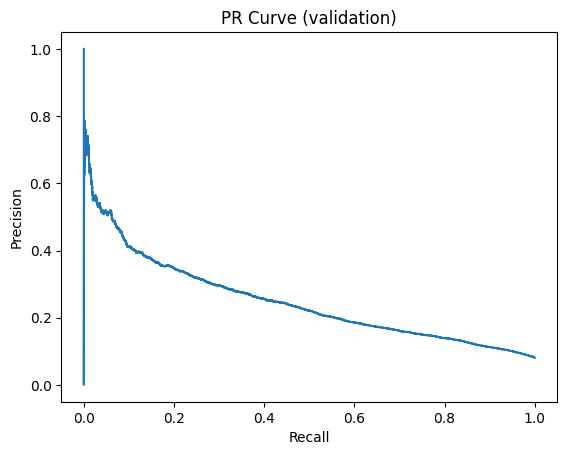

In [20]:
# =========================================================
# 9) (OPTIONAL) SIMPLE THRESHOLD TUNING DEMO
#    Choose a threshold that improves recall/precision tradeoff
# =========================================================
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use the best model's validation probabilities again for demo
X_tr, X_va, y_tr, y_va = train_test_split(X_full, y_full, test_size=0.20, random_state=RANDOM_STATE, stratify=y_full)
best_pipe.fit(X_tr, y_tr)

if hasattr(best_pipe[-1], "predict_proba"):
    va_proba = best_pipe.predict_proba(X_va)[:, 1]
else:
    va_proba = best_pipe.predict(X_va).astype(float)

ap = average_precision_score(y_va, va_proba)
prec, rec, thr = precision_recall_curve(y_va, va_proba)
print(f"Validation Average Precision (area under PR curve): {ap:.4f}")

# Find threshold that maximizes F1
f1s = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1s)
print(f"Best F1 ~ {f1s[best_idx]:.4f} at threshold={thr[max(best_idx-1,0)]:.4f}")

# Plot PR curve
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (validation)")
plt.show()